## Let's sum up all the analysis in a single dataframe !

In [1]:

import sys,os
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df

def get_results_df(_internal_task_id,_studies_list = None,_exclude_subjects_list = [],
                   _llm_classification_code = None, _llm_classification_file_path = None,
                   _bins_fb_noise = None,
                   _override = False,
                   last_k_trials= 5,last_t_timesteps=5):
    
    if _studies_list is not None :
        # Get a list of the task results, 
        _tasks_results_all = []
        for prolific_study_id in _studies_list:
            task_results = get_all_subject_data_from_internal_task_id(_internal_task_id,prolific_study_id,
                                                                    process_feedback_data_stream=True,override_save=_override)
            print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
            _tasks_results_all += task_results
    else :
        _tasks_results_all = get_all_subject_data_from_internal_task_id(_internal_task_id,
                                                                        process_feedback_data_stream=True,override_save=_override)
        
    print("Total : {} subjects".format(len(_tasks_results_all)))



    # Each subject in task results has the following entries : 
    # TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
    
    # let's remove some subjects based on broad inclusion criteria : 
    # did not do the task twice, did not revoke the consent midpoint, etc.
    remove_these_subjects = []
    for index,entry in enumerate(_tasks_results_all):
        subj_dict,_,_,_ = entry
        subj_name = subj_dict["subject_id"]
        if subj_name in _exclude_subjects_list:
            remove_these_subjects.append(index)

    _tasks_results_all = remove_by_indices(_tasks_results_all,remove_these_subjects)
    print(str(len(_tasks_results_all)) + " subjects remaining after removing problematic subjects.")
    
    
    
    # Fill a dataframe with that data :
    
    
    
    # The initial datframe is the first tuple in our task result list of tuples : 
    subjects_df = pd.DataFrame([entry[0] for entry in _tasks_results_all])

    # Avoid too many categories : 
    subjects_df['Sex'] = np.where(subjects_df['Sex'].isin(['Male','Female']), subjects_df['Sex'], 'Other')

    category_counts = subjects_df['Nationality'].value_counts()
    threshold = 2
    subjects_df['Nationality_red'] = subjects_df['Nationality'].apply(lambda x: x if category_counts[x] >= threshold else 'Other')

    # There was a single noise term for the whole training for each subject : 
    subject_noise_parameters = [np.array(entry[2]["parameters"]["noise_int"])[0] for entry in _tasks_results_all]

    # We add it to the df : 
    subjects_df["feedback_noise_std"] = subject_noise_parameters

    # Time taken to solve the task 
    # Add the time taken recorded by the application : (a better measure than the one provided by Prolific for some reason)
    # subjects_df["application_measured_timetaken"] = (subjects_df["finish_date"]-subjects_df["start_date"]).dt.total_seconds()

    subjects_df["application_measured_timetaken"] = (pd.to_datetime(subjects_df["finish_date"])-pd.to_datetime(subjects_df["start_date"])).dt.total_seconds()

    
    
    
    
    
    
    
    
    
    # In this dataframe, we're interested in sorting various kinds of data from the trials : 
    # 1/ Data from the instruction phase
    # Load LLM classifications for text responses if they are available !
    if _llm_classification_code is not None :
        classification_instructions = {}
        try : 
            with open(_llm_classification_file_path, 'rb') as f:
                loaded_dict = pickle.load(f)
                
            for question_code,question_contents in loaded_dict.items():
                
                subject_classifs = question_contents["results"][_llm_classification_code]    

                
                subjects_df[question_code] = subject_classifs
                classification_instructions[question_code] = {
                    "prompt" : question_contents["prompt"],
                    "template" : question_contents["template"],
                }
                # print(subject_classifs)
            
        except : 
            print("Failed to load LLM classifications.")
    

    # 2/ Data from the feedback gauge :
    # Timestep values :
    all_subject_scores = [subjdata[2]["scoring"] for subjdata in _tasks_results_all]
    subjects_df["raw_feedback_values"] = [subj_scores["feedback"] for subj_scores in all_subject_scores]
    # Real time gauge values :
    subjects_df["realtime_values"] = [subjdata[3][1] for subjdata in _tasks_results_all] # Each element is a list of list os arrays (with varying shape)

    # 3/ Data from the hidden grid :
    # The grid for a specific trial: 
    trial_grids = [entry[2]["process"]["grids"] for entry in _tasks_results_all]
    subjects_df["grid_layout"] = trial_grids
    # Position value :
    subject_positions = [entry[2]["process"]["positions"] for entry in _tasks_results_all]
    subjects_df["subject_positions"] = subject_positions

    goal_positions = [np.array(entry[2]["parameters"]["goal_pos"])[:,0,:] for entry in _tasks_results_all]
    subjects_df["goal_position"] = goal_positions

    def euclidian_distance(position,goal):
        return jnp.linalg.norm(position-goal,2)
    gs = trial_grids[0][0].shape
    maximum_euclidian_dist = euclidian_distance(jnp.array(gs) - jnp.ones((2,)),jnp.zeros((2,)))
    all_euclidian_distances = vmap(vmap(vmap(euclidian_distance,in_axes=(0,None))))(jnp.array(subject_positions),jnp.array(goal_positions))/maximum_euclidian_dist
    subjects_df["norm_distance_to_goal"] = list(all_euclidian_distances)


    # 4/ Data from the realized actions :

    # Actions performed : this encompasses the points dropped
    # But may also include temporal elements such as :
    # - the time taken to perform an actions (first point / second point)
    # - when the action was performed with regard to the gauge
    canvas_size = _tasks_results_all[0][0]["canvas_size"] # Constant across all subjects + conditions
    all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in _tasks_results_all]).astype(float)

    Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape
    # print(all_actions_data)
    # Normalize the point data :
    all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
    all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]


    # First, let's get a mask for all actions that were NOT performed :
    mask = all_actions_data[...,-1]==1  # values are 1 if the point was recorded
    both_points_only = (mask[...,0] & mask[...,1])
        # All points where at least one value is missing

    Nactions = all_actions_data[...,0,0].size
    Nmissed_actions = (~both_points_only).sum()
    print("A total of {}/{} actions were missed. ({:.2f} %)".format(Nmissed_actions,Nactions,100*Nmissed_actions/Nactions))

    subjects_df["raw_points"] = list(all_actions_data)


    # Encoded barycenters :
    barycenter_x = (all_actions_data[...,0,0]+all_actions_data[...,1,0])/2.0
    barycenter_y = (all_actions_data[...,0,1]+all_actions_data[...,1,1])/2.0
    barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)
    subjects_df["action_barycenters"] = list(barycenters)

    # Encoded euclidian distance between points :
    action_distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
    subjects_df["action_distances"] = list(action_distances)

    # Encoded evolution of point angles :
    angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
    subjects_df["action_angles"] = list(angles)

    # Encoded delays between stimuli, point1 and point2 :
    all_action_delays = all_actions_data[...,-1,2]
    unfit_actions = (all_action_delays<10)
    subjects_df["action_time_between_points"] = np.where(all_action_delays>10, all_action_delays, np.nan).tolist()

    # Performance metric : we use the average distance to goal state across the lask k_T trials and the last k_t timesteps : (ignoring the blind trial)
    all_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-last_k_trials:-1,-last_t_timesteps:],axis=(-1,-2))
    subjects_df["final_performance"] = (1.0 - all_distances_to_goal).tolist()


    # And for the blind trial :
    blind_trial_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-1,-last_t_timesteps:],axis=(-1))
    subjects_df["blind_trial_performance"] = (1.0 - blind_trial_distances_to_goal).tolist()
    
    
    
    
    
    # In our situation, the variables of interest are : 
    # a/ The level of noise of the gauge
    # b/ The performance of the subject
    # Let's define broad categories to classify them a bit easier :
    if _bins_fb_noise is None:
        subjects_df['noise_category'] = pd.cut(subjects_df['feedback_noise_std'], bins=[0,0.05,0.15,1.0], labels=["Low", "Medium", "High"])
    else : 
        subjects_df['noise_category'] = pd.cut(subjects_df['feedback_noise_std'], bins=_bins_fb_noise, labels=["Low", "Medium", "High"])
    
    _bins_performance_data = np.linspace(0,1,4)
    _bins_performance_data = np.array([0.0,0.2,0.8,1.0])
    subjects_df['performance_category'] = pd.cut(subjects_df['final_performance'], bins=_bins_performance_data, labels=["Poor", "Middling", "Good"])
    
    
    
    
    
    return subjects_df,classification_instructions
    
    
LLM_CLASSIFS_PATH = os.path.join("results","llm_classifications","cluster_12_02.data")

STUDIES_EXTRACTION_CODES = {
    "study_1" : {
        "dict_code" : "002",
        "internal_task_id" : "002",
        "studies_id" : None,
        "exclude_subjects" : ["5c9cb670b472d0001295f377"],
        "feedback_noise_bins" : [0,0.2,0.4,1]
    },
    "study_2" : {
        "dict_code" : "003_1",
        "internal_task_id" : "003",
        "studies_id" :  ["66f96c31e69227986334a027","66d086503c0a69291c361b67"],
        "exclude_subjects" : ["615c1741d4630b25e6bc1cb9"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    },
    "study_3" : {
        "dict_code" : "003_2",
        "internal_task_id" : "003",
        "studies_id" : ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"],
        "exclude_subjects" : ["611d60c383f4f70ff4bc99fd", "66a74bdfdcaccdc0703894d5",
                              "667d92f2ea5c1542f417285d", "6548f570022275786186ffbd"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    }
}


full_dataframe = pd.DataFrame()
for study_name,study_codes in STUDIES_EXTRACTION_CODES.items() :

    dataframe,qsts = get_results_df(study_codes["internal_task_id"],_studies_list = study_codes["studies_id"],_exclude_subjects_list = study_codes["exclude_subjects"],
                    _llm_classification_code = study_codes["dict_code"], _llm_classification_file_path = LLM_CLASSIFS_PATH,
                    _bins_fb_noise = study_codes["feedback_noise_bins"],
                    _override = False)
    dataframe["study_name"] = study_name
    
    full_dataframe = pd.concat([full_dataframe,dataframe],ignore_index=True)
    
print(full_dataframe.columns)

Total : 90 subjects
89 subjects remaining after removing problematic subjects.
A total of 1557/9790 actions were missed. (15.90 %)
 - Loaded the task results for study 66f96c31e69227986334a027 
    (16 subjects.)
 - Loaded the task results for study 66d086503c0a69291c361b67 
    (40 subjects.)
Total : 56 subjects
55 subjects remaining after removing problematic subjects.
A total of 14/6050 actions were missed. (0.23 %)
 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.
A total of 33/15950 actions were missed. (0.21 %)
Index(['subject_id', 'task_code', 'lang', 'browser', 'N_trials', 'N_tmstps',
       'start_date', 'finish_date', 'finished_clock', 'completedTask',
       'N_exited_fullscreen', 'N_missed_actions', 'c

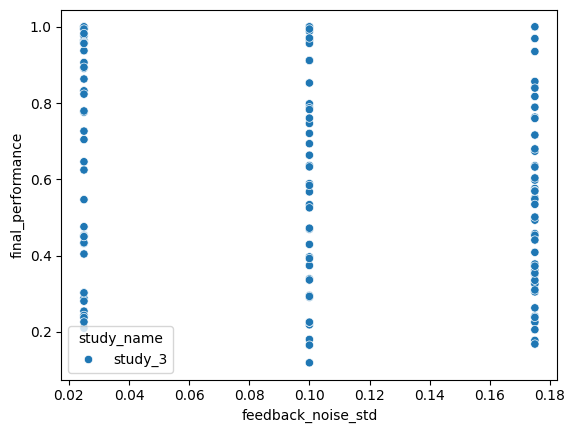

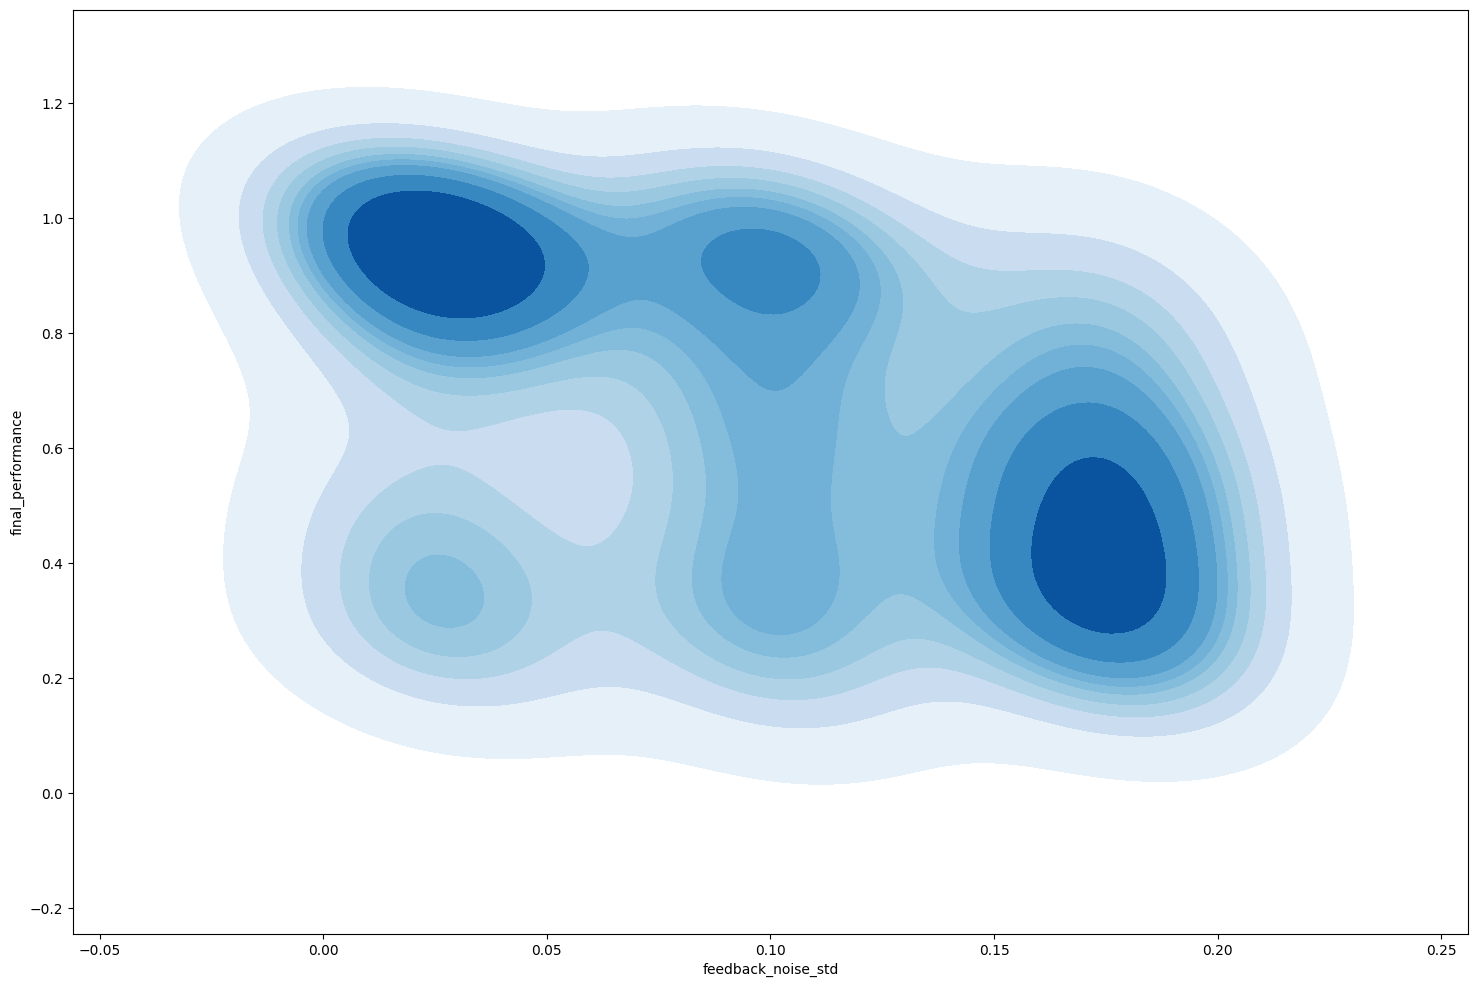

C:\Users\annic\AppData\Local\Temp\ipykernel_28880\1402253271.py:13: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=ax,data=plot_this_dataframe[filter], x='feedback_noise_std', y='final_performance', cmap='Reds', fill=False, label='Study 2')


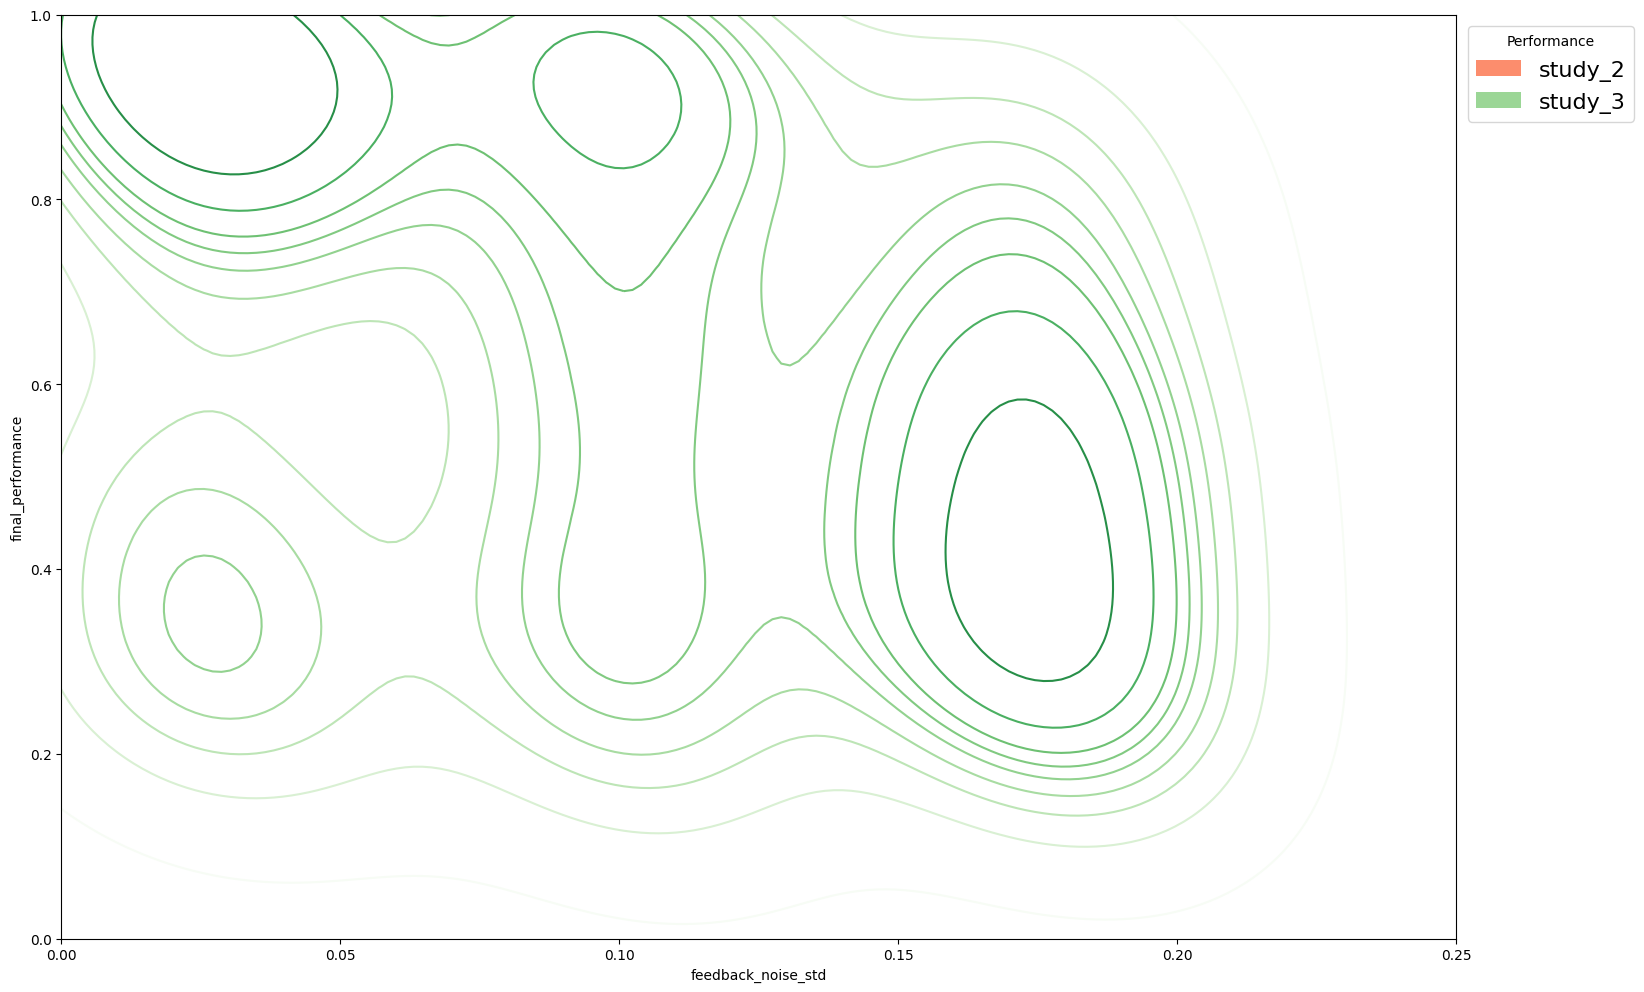

In [13]:

plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]
plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" )]
sns.scatterplot(data=plot_this_dataframe,x="feedback_noise_std",y="final_performance",hue="study_name")
plt.show()

fig,ax=plt.subplots(1,1,figsize=(18,12))
sns.kdeplot(ax=ax,data=plot_this_dataframe, x='feedback_noise_std', y='final_performance', cmap='Blues', fill=True)
plt.show()


fig,ax=plt.subplots(1,1,figsize=(18,12))
filter = plot_this_dataframe["study_name"] == "study_2"
sns.kdeplot(ax=ax,data=plot_this_dataframe[filter], x='feedback_noise_std', y='final_performance', cmap='Reds', fill=False, label='Study 2')

filter = plot_this_dataframe["study_name"] == "study_3"
sns.kdeplot(ax=ax,data=plot_this_dataframe[filter], x='feedback_noise_std', y='final_performance', cmap='Greens', fill=False, label='Study 3')
import matplotlib.patches as  mpatches
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="study_2"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="study_3")]
ax.legend(handles=handles,title="Performance", fontsize=16, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylim([0,1])
ax.set_xlim([0,0.25])
plt.show()


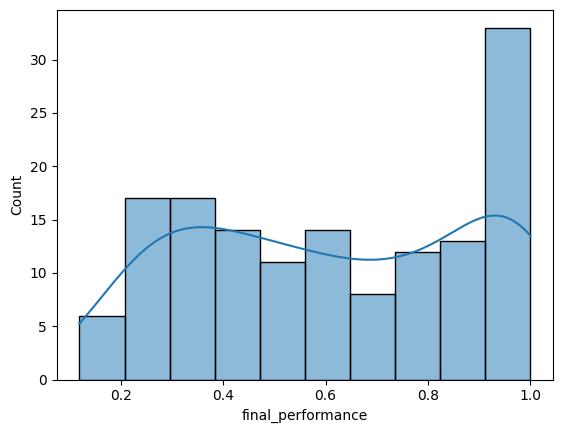

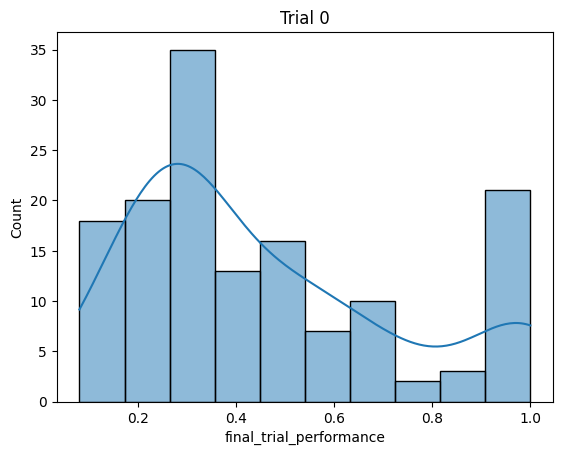

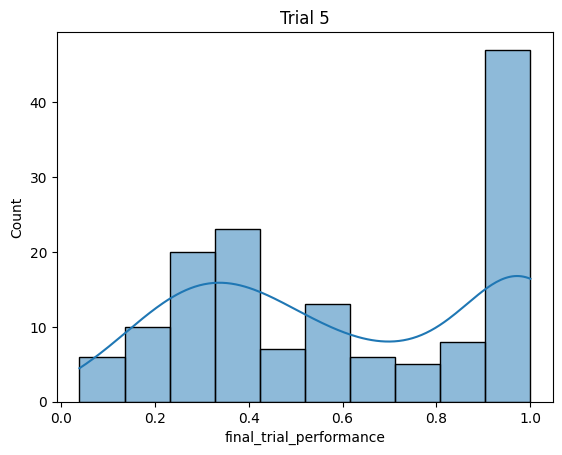

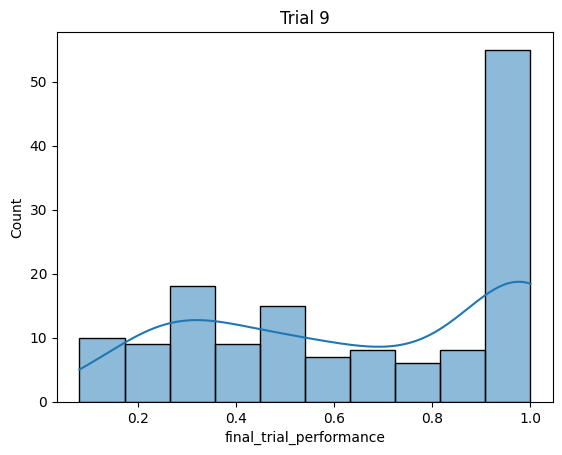

In [14]:

plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]
plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" )]

sns.histplot(data=plot_this_dataframe,x="final_performance",kde=True,bins=10)
plt.show()


eps = 0.2
tfin = 2

# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
all_distances = np.stack(plot_this_dataframe['norm_distance_to_goal'])[:,:-1,:]
Nsubjs = plot_this_dataframe.shape[0]

# Only look at the last timesteps avg : 
all_distances = np.mean(all_distances[:,:,-tfin:],axis=-1)
Nsteps = all_distances.shape[-1]

all_subject_indexes = np.repeat(np.expand_dims(np.arange(Nsubjs),1),Nsteps,1)
all_trials_indexes = np.repeat(np.expand_dims(np.arange(Nsteps),0),Nsubjs,0)
all_subject_noise_cat = np.repeat(np.expand_dims(np.array(plot_this_dataframe['noise_category']),1),Nsteps,1)
all_noises = np.repeat(np.expand_dims(np.array(plot_this_dataframe['feedback_noise_std']),1),Nsteps,1)

# Dataframe : columns : step x subject_id x noise_level x final_feedback x final_distance
new_df = pd.DataFrame()
new_df["trial"] = list(all_trials_indexes.flatten())
new_df["subject"] = list(all_subject_indexes.flatten())
new_df["final_trial_performance"] = list(1.0 - all_distances.flatten())
new_df["noise"] = list(all_noises.flatten())
new_df['noise_cat'] = list(all_subject_noise_cat.flatten())

for trial in [0,5,9]:
    filter = new_df["trial"] == trial
    sns.histplot(data=new_df[filter],x="final_trial_performance",kde=True,bins=10)
    plt.title("Trial {}".format(trial))
    plt.show()


## Gaussian mixture model 


(1450, 1)
Initial Means:
[[0.76843026]
 [0.50858213]
 [0.25260481]]

Initial Covariances:
[[[0.00127279]]

 [[0.01704311]]

 [[0.0075913 ]]]


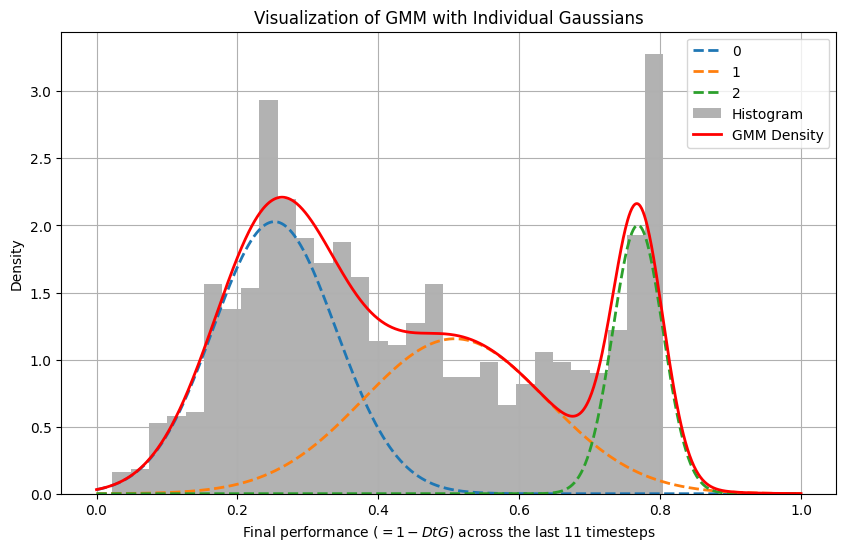

In [16]:
import sklearn

plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]
plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" )]

eps = 0.2
tfin = 11  # The number of timesteps to average over when computing the final performance

# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
all_distances = np.stack(plot_this_dataframe['norm_distance_to_goal'])[:,:-1,:]
Nsubjs = plot_this_dataframe.shape[0]

# Only look at the last timesteps avg : 
all_distances = np.mean(all_distances[:,:,-tfin:],axis=-1)
Nsteps = all_distances.shape[-1]

all_subject_indexes = np.repeat(np.expand_dims(np.arange(Nsubjs),1),Nsteps,1)
all_trials_indexes = np.repeat(np.expand_dims(np.arange(Nsteps),0),Nsubjs,0)
all_subject_noise_cat = np.repeat(np.expand_dims(np.array(plot_this_dataframe['noise_category']),1),Nsteps,1)
all_noises = np.repeat(np.expand_dims(np.array(plot_this_dataframe['feedback_noise_std']),1),Nsteps,1)

fit_this = np.reshape(1.0 - all_distances.flatten(),(-1,1))
print(fit_this.shape)




from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=43).fit(fit_this)
# Print the initial parameters
print("Initial Means:")
print(gm.means_)
print("\nInitial Covariances:")
print(gm.covariances_)


# Visualize the fitted mixture of gaussians :
# Step 4: Plot the histogram of the data and the GMM density
plt.figure(figsize=(10, 6))
# Step 3: Define a range of values to evaluate the GMM density
x = np.linspace(0, 1, 1000).reshape(-1, 1)
density = np.exp(gm.score_samples(x))  # Convert log-likelihood to density
# Calculate the individual Gaussian densities
def gaussian_pdf(x, mean, var):
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((x - mean) ** 2) / var)

weights = gm.weights_
means = gm.means_.flatten()
covariances = gm.covariances_.flatten()
# cholesky = gm.precisions_cholesky_.flatten()

# Sort the components by increasing mean value
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_weights = weights[sorted_indices]
sorted_covariances = covariances[sorted_indices]

individual_densities = [
    sorted_weights[i] * gaussian_pdf(x.flatten(), sorted_means[i], sorted_covariances[i])
    for i in range(gm.n_components)
]

# Plot individual Gaussians
for i, (ind_density) in enumerate(individual_densities):
    plt.plot(x, ind_density, linestyle='--', linewidth=2, label=i)
# Histogram of the data
plt.hist(fit_this, bins=30, density=True, alpha=0.6, color='gray', label='Histogram')
# GMM density
plt.plot(x, density, color='red', linewidth=2, label='GMM Density')
plt.title('Visualization of GMM with Individual Gaussians')
plt.xlabel('Final performance ($= 1 - DtG$) across the last {} timesteps'.format(tfin))
plt.ylabel('Density')
plt.legend()
plt.grid(True)

C:\Users\annic\AppData\Local\Temp\ipykernel_28880\2018699605.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\annic\AppData\Local\Temp\ipykernel_28880\2018699605.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\annic\AppData\Local\Temp\ipykernel_28880\2018699605.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\annic\AppData\Local\Temp\ipykernel_28880\2018699605.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


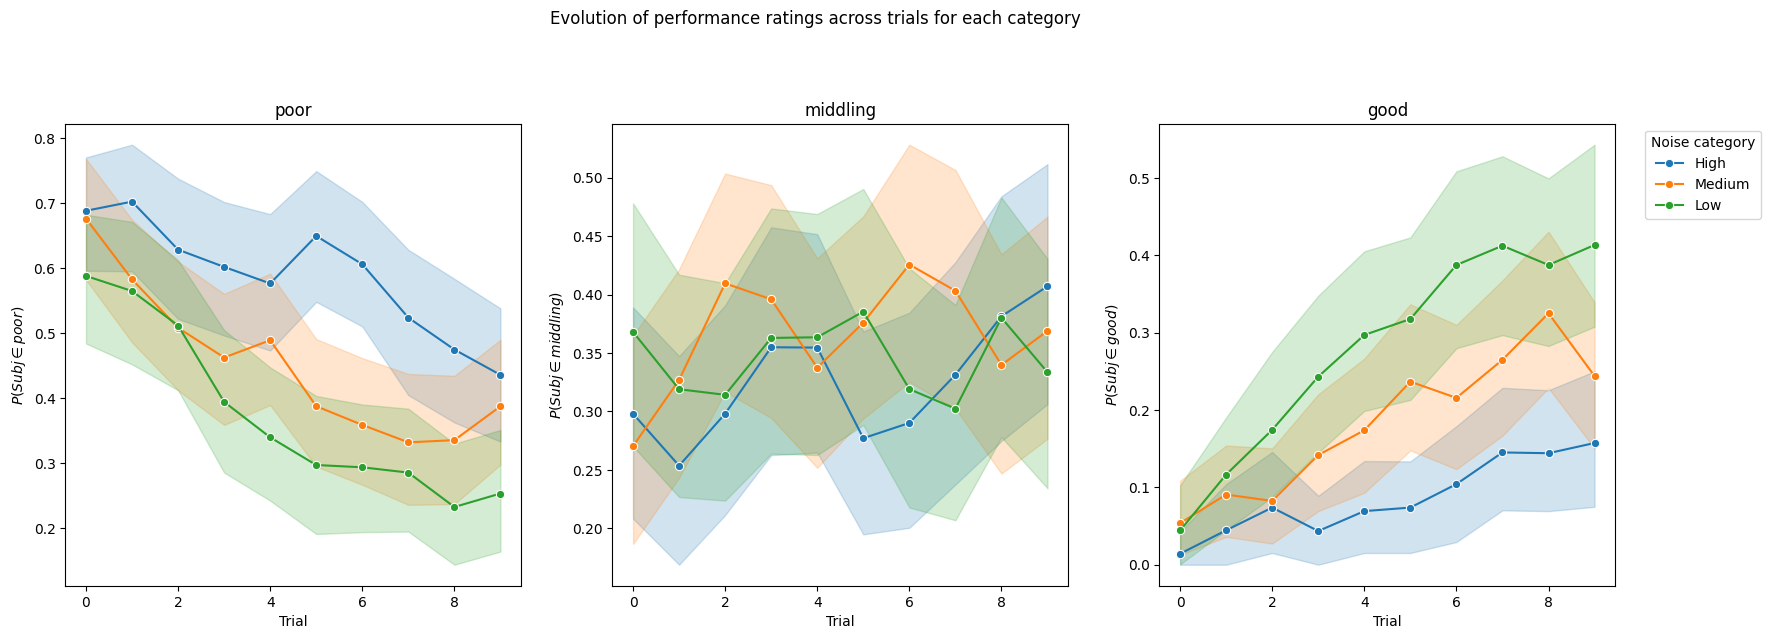

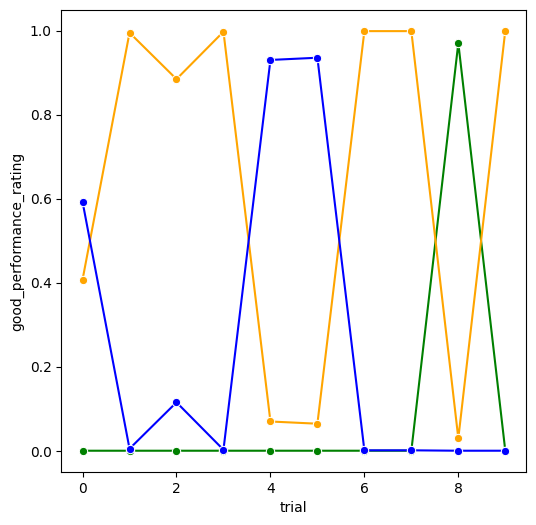

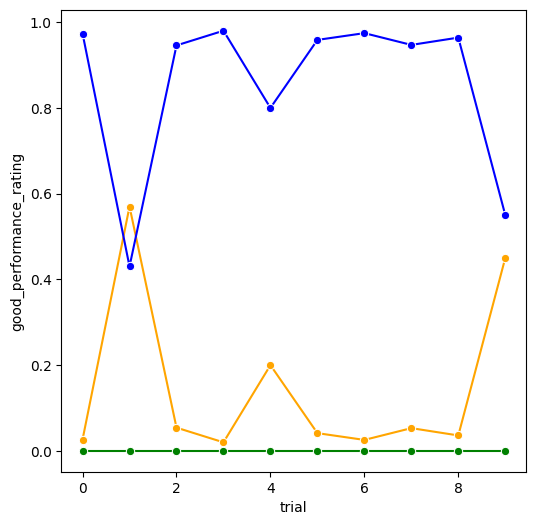

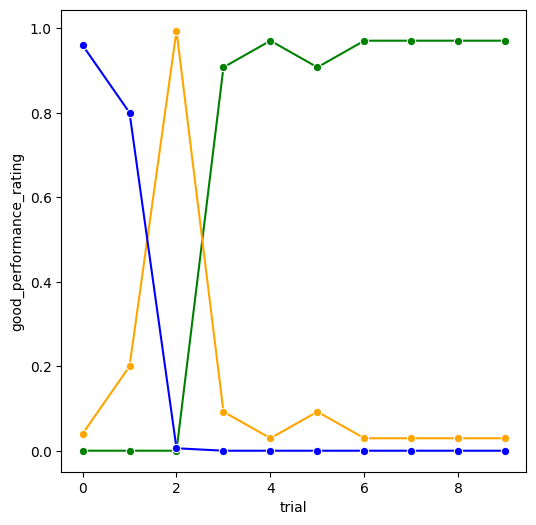

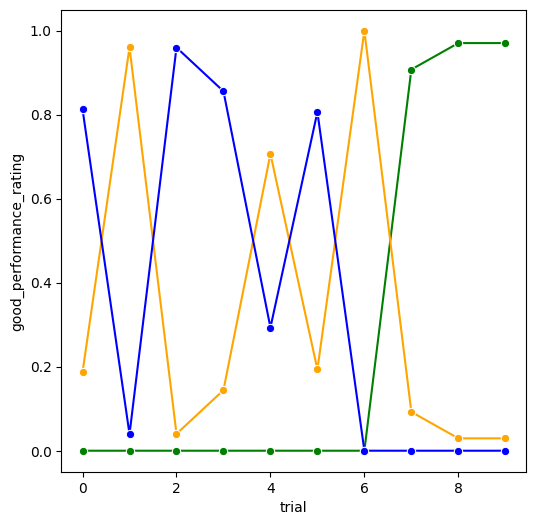

In [5]:

plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]

# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
all_distances = np.stack(plot_this_dataframe['norm_distance_to_goal'])[:,:-1,:]
Nsubjs = plot_this_dataframe.shape[0]

# Only look at the last timesteps avg : 
all_distances = np.mean(all_distances[:,:,-tfin:],axis=-1)
Nsteps = all_distances.shape[-1]

all_subject_indexes = np.repeat(np.expand_dims(np.arange(Nsubjs),1),Nsteps,1)
all_trials_indexes = np.repeat(np.expand_dims(np.arange(Nsteps),0),Nsubjs,0)
all_subject_noise_cat = np.repeat(np.expand_dims(np.array(plot_this_dataframe['noise_category']),1),Nsteps,1)
all_noises = np.repeat(np.expand_dims(np.array(plot_this_dataframe['feedback_noise_std']),1),Nsteps,1)

# Dataframe : columns : step x subject_id x noise_level x final_feedback x final_distance
new_df = pd.DataFrame()
new_df["trial"] = list(all_trials_indexes.flatten())
new_df["subject"] = list(all_subject_indexes.flatten())
new_df["final_trial_performance"] = list(1.0 - all_distances.flatten())
new_df["noise"] = list(all_noises.flatten())
new_df['noise_cat'] = list(all_subject_noise_cat.flatten())

# Temporal evolution of each subject "belonging" across categories :

# Create a new GaussianMixture with the same parameters but no fitting
gmm_fixed = GaussianMixture(n_components=3, random_state=42)
gmm_fixed.means_ = gm.means_[sorted_indices]
gmm_fixed.covariances_ = gm.covariances_[sorted_indices]
gmm_fixed.weights_ = gm.weights_[sorted_indices]
gmm_fixed.precisions_cholesky_ = gm.precisions_cholesky_[sorted_indices] # Needed to avoid re-fitting


# Predict cluster assignments for the new time step
new_df["assignment"] = list(gmm_fixed.predict_proba(np.expand_dims(new_df["final_trial_performance"].to_numpy(),-1)))
new_df["poor_performance_rating"] = new_df["assignment"].apply(lambda x: x[0])
new_df["middling_performance_rating"] = new_df["assignment"].apply(lambda x: x[1])
new_df["good_performance_rating"] = new_df["assignment"].apply(lambda x: x[2])


# Figure : evolution of all subject ratings across trials
fig,axes=plt.subplots(1,3,figsize=(20,6))
fig.suptitle("Evolution of performance ratings across trials for each category",y=1.07)
for i,perf_cat in enumerate(["poor","middling","good"]):
    legend = (i==2)
        
    sns.lineplot(ax=axes[i],data=new_df,x="trial",y=perf_cat+"_performance_rating",hue="noise_cat", marker='o', legend=legend)
    
    axes[i].set_title((perf_cat))
    axes[i].set_xlabel("Trial")
    axes[i].set_ylabel("$P(Subj \in {})$".format(perf_cat))
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Noise category")

# Figure : evolution of individual subjects :

subjs = [1,4,67,145]
for s in subjs :
    fig,axes=plt.subplots(1,1,figsize=(6,6))
    sns.lineplot(ax=axes,data=new_df[new_df["subject"]==s],x="trial",y="good_performance_rating",marker='o',color="green", legend=False)
    sns.lineplot(ax=axes,data=new_df[new_df["subject"]==s],x="trial",y="middling_performance_rating",color="orange", marker='o', legend=False)
    sns.lineplot(ax=axes,data=new_df[new_df["subject"]==s],x="trial",y="poor_performance_rating",color="blue", marker='o', legend=False)
    fig.show()

In [6]:

plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]

# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
all_distances = np.stack(plot_this_dataframe['norm_distance_to_goal'])[:,:-1,:]
Nsubjs = plot_this_dataframe.shape[0]

# Only look at the last timesteps avg : 
all_distances = np.mean(all_distances[:,:,-tfin:],axis=-1)
Nsteps = all_distances.shape[-1]

all_subject_indexes = np.repeat(np.expand_dims(np.arange(Nsubjs),1),Nsteps,1)
all_trials_indexes = np.repeat(np.expand_dims(np.arange(Nsteps),0),Nsubjs,0)
all_subject_noise_cat = np.repeat(np.expand_dims(np.array(plot_this_dataframe['noise_category']),1),Nsteps,1)
all_noises = np.repeat(np.expand_dims(np.array(plot_this_dataframe['feedback_noise_std']),1),Nsteps,1)

# Dataframe : columns : step x subject_id x noise_level x final_feedback x final_distance
new_df = pd.DataFrame()
new_df["trial"] = list(all_trials_indexes.flatten())
new_df["subject"] = list(all_subject_indexes.flatten())
new_df["final_trial_performance"] = list(1.0 - all_distances.flatten())
new_df["noise"] = list(all_noises.flatten())
new_df['noise_cat'] = list(all_subject_noise_cat.flatten())

# Temporal evolution of each subject "belonging" across categories :

# Create a new GaussianMixture with the same parameters but no fitting
gmm_fixed = GaussianMixture(n_components=3, random_state=42)
gmm_fixed.means_ = gm.means_[sorted_indices]
gmm_fixed.covariances_ = gm.covariances_[sorted_indices]
gmm_fixed.weights_ = gm.weights_[sorted_indices]
gmm_fixed.precisions_cholesky_ = gm.precisions_cholesky_[sorted_indices] # Needed to avoid re-fitting


# Predict cluster assignments for the new time step
new_df["assignment"] = list(gmm_fixed.predict_proba(np.expand_dims(new_df["final_trial_performance"].to_numpy(),-1)))
new_df["poor_performance_rating"] = new_df["assignment"].apply(lambda x: x[0])
new_df["middling_performance_rating"] = new_df["assignment"].apply(lambda x: x[1])
new_df["good_performance_rating"] = new_df["assignment"].apply(lambda x: x[2])


fig,axs = plt.subplots(3,1,figsize=(120,100))
for k,group in enumerate(["poor_performance_rating","middling_performance_rating","good_performance_rating"]):
    ax = axs[k]
    
    last_trial_perfs =  new_df[(new_df["trial"]==9)&(new_df[group]>0.5)]
    filtered_df = new_df[new_df['subject'].isin(last_trial_perfs['subject'])]

    # print(subsec)
    all_subjects_trial = []
    for trial in range(10):
        trial_df = filtered_df[filtered_df["trial"]==trial]
        assigns = np.vstack(trial_df["assignment"])
        all_subjects_trial.append(assigns)
    print(np.array(all_subjects_trial).shape)

   
    ax.imshow(np.array(all_subjects_trial))

(10, 74, 3)
(10, 69, 3)
(10, 57, 3)


[[0.48674667]
 [0.8572036 ]
 [0.96464467]
 [0.86882401]
 [0.33028615]
 [0.38969183]
 [0.30880553]
 [0.45199233]
 [0.10549289]
 [0.20602548]
 [0.68026221]
 [0.97642976]
 [0.15355414]
 [0.48411781]
 [0.91750419]
 [0.97053719]
 [0.61719954]
 [0.80714452]
 [0.57674545]
 [0.46066391]
 [0.82322329]
 [0.99410743]
 [1.        ]
 [0.58752102]
 [0.73615617]
 [0.7416091 ]
 [1.        ]
 [1.        ]
 [0.93144357]
 [1.        ]
 [0.55158216]
 [0.84241003]
 [0.98821491]
 [0.52027166]
 [0.97398901]
 [0.96325362]
 [0.88214886]
 [0.99410743]
 [0.49810529]
 [0.89355391]
 [0.14800441]
 [0.27144241]
 [0.76990378]
 [0.20141971]
 [0.59869611]
 [0.30549502]
 [0.52836239]
 [0.84491479]
 [0.25576222]
 [0.61628199]
 [0.33966148]
 [0.91161168]
 [0.6572755 ]
 [0.4202764 ]
 [0.59741634]
 [0.95968539]
 [0.66335249]
 [0.6362744 ]
 [0.33915997]
 [0.97053719]
 [0.29105759]
 [0.46949327]
 [0.97015715]
 [0.85268605]
 [0.74653733]
 [0.53387856]
 [0.18046826]
 [1.        ]
 [0.52540767]
 [0.91161168]
 [0.29569447]
 [0.98

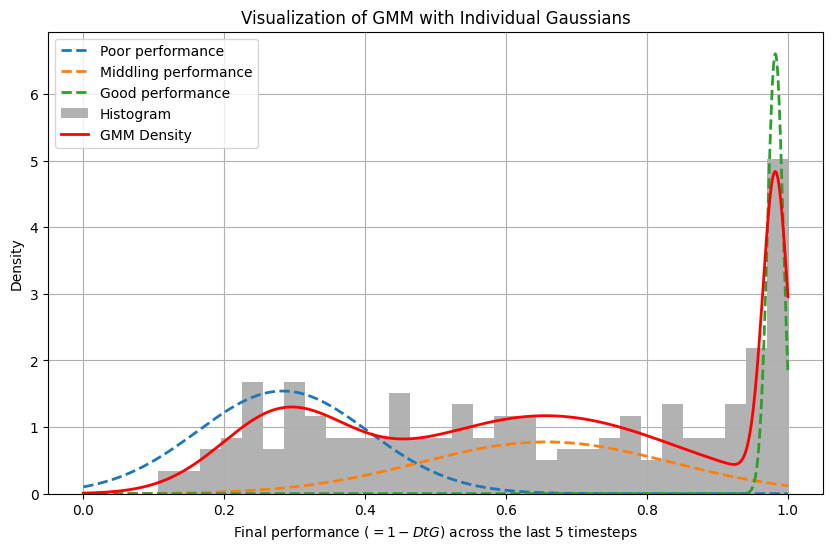

[1 1 2 1 0 0 0 1 0 0 1 2 0 1 1 2 1 1 1 1 1 2 2 1 1 1 2 2 1 2 1 1 2 1 2 2 1
 2 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 2 1 1 0 2 0 1 2 1 1 1 0 2 1 1 0 2 1 1
 1 0 1 1 0 2 1 2 1 1 2 2 0 0 1 1 0 0 1 0 0 1 2 0 1 0 2 1 2 2 1 1 1 1 1 1 0
 1 1 1 1 2 2 2 2 1 2 2 1 2 0 0 2 2 1 2 0 2 1 2 2 1 1 0 1 0 0 1 1 0 1 2 1 0
 1 2 2 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 2 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 1 1 0 1 0 0 2 1 1 1 0 1]
(200, 3)
Posterior probabilities for the first data point:


C:\Users\annic\AppData\Local\Temp\ipykernel_28880\4235244860.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_this_dataframe["poor_performance_rating"] = list(posteriors[:,0])
C:\Users\annic\AppData\Local\Temp\ipykernel_28880\4235244860.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_this_dataframe["middling_performance_rating"] = list(posteriors[:,1])
C:\Users\annic\AppData\Local\Temp\ipykernel_28880\4235244860.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Text(0.5, 0, 'Avg. performance across the last 5 timesteps & 3 trials')

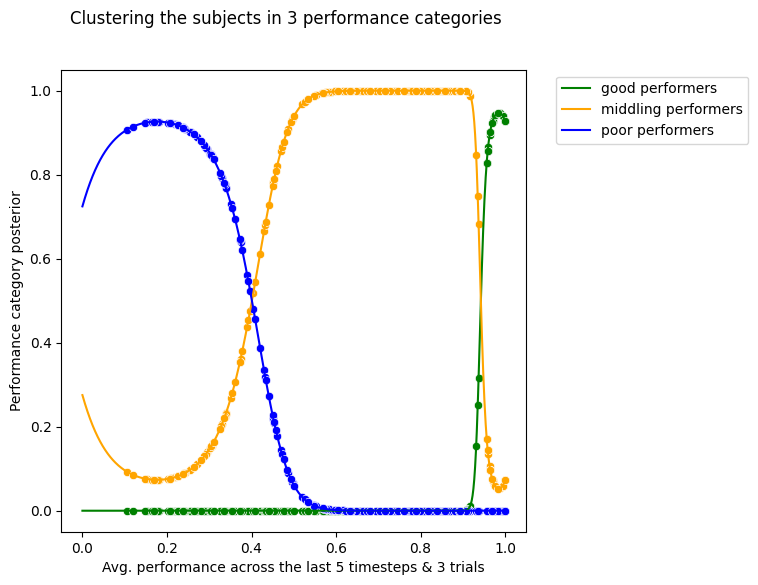

In [7]:
from sklearn.mixture import GaussianMixture


plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]


fit_this = np.expand_dims(plot_this_dataframe["final_performance"].to_numpy(),-1)
print(fit_this)


gm = GaussianMixture(n_components=3, random_state=43).fit(fit_this)
# Print the initial parameters
print("Initial Means:")
print(gm.means_)
print("\nInitial Covariances:")
print(gm.covariances_)

weights = gm.weights_
means = gm.means_.flatten()
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
covariances = gm.covariances_.flatten()

# Create a new GaussianMixture with the same parameters but no fitting
gmm_fixed = GaussianMixture(n_components=3, random_state=42)
gmm_fixed.means_ = gm.means_[sorted_indices]
gmm_fixed.covariances_ = gm.covariances_[sorted_indices]
gmm_fixed.weights_ = gm.weights_[sorted_indices]
gmm_fixed.precisions_cholesky_ = gm.precisions_cholesky_[sorted_indices] # Needed to avoid re-fitting






# Visualize the fitted mixture of gaussians :
# Step 4: Plot the histogram of the data and the GMM density
plt.figure(figsize=(10, 6))
# Step 3: Define a range of values to evaluate the GMM density
x = np.linspace(0, 1, 1000).reshape(-1, 1)
density = np.exp(gm.score_samples(x))  # Convert log-likelihood to density
# Calculate the individual Gaussian densities
def gaussian_pdf(x, mean, var):
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((x - mean) ** 2) / var)
# Plot individual Gaussians
individual_densities = [
    sorted_weights[i] * gaussian_pdf(x.flatten(), sorted_means[i], sorted_covariances[i])
    for i in range(gm.n_components)
]
for i, (ind_density,cat_label) in enumerate(zip(individual_densities,["Poor performance","Middling performance","Good performance"])):
    plt.plot(x, ind_density, linestyle='--', linewidth=2, label=cat_label)
# Histogram of the data
plt.hist(fit_this, bins=30, density=True, alpha=0.6, color='gray', label='Histogram')
# GMM density
plt.plot(x, density, color='red', linewidth=2, label='GMM Density')
plt.title('Visualization of GMM with Individual Gaussians')
plt.xlabel('Final performance ($= 1 - DtG$) across the last {} timesteps'.format(tfin))
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()




# Predict the cluster labels
labels = gmm_fixed.predict(fit_this)
print(labels)
# Get the posterior probabilities for each data point (classification probabilities)
posteriors = gmm_fixed.predict_proba(fit_this)
print(posteriors.shape)
plot_this_dataframe["poor_performance_rating"] = list(posteriors[:,0])
plot_this_dataframe["middling_performance_rating"] = list(posteriors[:,1])
plot_this_dataframe["good_performance_rating"] = list(posteriors[:,2])


# Print the posterior for the first data point as an example
print("Posterior probabilities for the first data point:")

all_vals = np.linspace(0,1.0,1000)
posteriors = gmm_fixed.predict_proba(np.expand_dims(all_vals,-1))
fig,ax = plt.subplots(1,1,figsize = ((6,6)))
fig.suptitle("Clustering the subjects in 3 performance categories")
ax.plot(all_vals,posteriors[:,2],color="green",label="good performers")
ax.plot(all_vals,posteriors[:,1],color="orange",label="middling performers")
ax.plot(all_vals,posteriors[:,0],color="blue",label="poor performers")
sns.scatterplot(data=plot_this_dataframe,x="final_performance",y="good_performance_rating",color="green")
sns.scatterplot(data=plot_this_dataframe,x="final_performance",y="middling_performance_rating",color="orange")
sns.scatterplot(data=plot_this_dataframe,x="final_performance",y="poor_performance_rating",color="blue")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Performance category posterior")
plt.xlabel("Avg. performance across the last {} timesteps & {} trials".format(tfin,3))